# EE Chula model3

In [ ]:
!ln -s ../data/ ./
!ln -s ../out/ ./

In [1]:
import os
import tensorflow as tf

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

tf.logging.set_verbosity(tf.logging.INFO)
sess = tf.InteractiveSession()

# Load train data

In [2]:
train = pd.read_csv('data/Train_data/dataset_rev4_train.csv')
#buffer datetime
buffer_datetime_train = train.datetime
#remove object
train = train.select_dtypes(exclude=['object'])
#replace misssing value
train.fillna(0,inplace=True)

# Load data for test

In [3]:
test = pd.read_csv('data/test_data/dataset_rev4_test.csv')
#buffer datetime
buffer_datetime_test = test.datetime
#remove object
test = test.select_dtypes(exclude=['object'])
#replace misssing value
test.fillna(0,inplace=True)

In [4]:
print('dimension of train:', train.shape)
print('dimension of test:', test.shape)

dimension of train: (131586, 6)
dimension of test: (16147, 5)


In [5]:
print("features:",list(train.columns))

features: ['I', 'T', 'UV', 'WS', 'RH', 'P']


# Input Function

In [6]:
def input_fn(data_set, pred = False):
    
    if pred == False:
        
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        labels = tf.constant(data_set[LABEL].values)
        
        return feature_cols, labels

    if pred == True:
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        
        return feature_cols

# Remove Outlier

In [7]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 13159
Number of rows without outliers: 118427


# Normalize

In [8]:
import warnings
warnings.filterwarnings('ignore')

col_train = list(train.columns)
col_train_bis = list(train.columns)

col_train_bis.remove('P')

mat_train = np.matrix(train)
mat_test  = np.matrix(test)

mat_new = np.matrix(train.drop('P',axis = 1))
mat_y = np.array(train.P).reshape((118427,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
test  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

train.head()

,I,T,UV,WS,RH,P
0,0.0,0.251029,0.0,0.033149,0.659910,0.0
1,0.0,0.246914,0.0,0.038674,0.664414,0.0
2,0.0,0.246914,0.0,0.052486,0.668919,0.0
3,0.0,0.246914,0.0,0.035912,0.671171,0.0
4,0.0,0.251029,0.0,0.038674,0.667230,0.0


# Create training_set and prediction_set

In [9]:
# List of features
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "P"

# Columns for tensorflow
feature_cols = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]

# Training set and Prediction set with the features to predict
training_set = train[COLUMNS]
prediction_set = train.P

In [10]:
print(type(training_set))
print(type(prediction_set))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


# Create x_train and Test

In [11]:
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.33, random_state=42)

In [12]:
print(type(x_train))
print(type(x_test))
print(type(y_train))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [13]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(79346, 5)
(39081, 5)
(79346,)
(39081,)


# Create training_set

In [14]:
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES).merge(y_train, left_index = True, right_index = True)
training_sub = training_set[col_train]

# Create testing_set

In [15]:
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES).merge(y_test, left_index = True, right_index = True)

# Create Model

In [16]:
# Model
tf.logging.set_verbosity(tf.logging.ERROR)
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[200, 100, 50, 25, 12])#,
                                         #optimizer = tf.train.GradientDescentOptimizer( learning_rate= 0.1 ))
#The optimizer used in our case is an Adagrad optimizer (by default).

# Reset the index of training

In [17]:
training_set.reset_index(drop = True, inplace =True)

In [18]:
training_set.shape

(79346, 6)

# Deep Neural Network Regressor with the training set which contain the data split by train test split

In [19]:
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7f0cff47d0b8>, 'hidden_units': [200, 100, 50, 25, 12], 'feature_columns': (_RealValuedColumn(column_name='I', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='T', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='UV', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='WS', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='RH', dimension=1, default_value=None, dtype=tf.float32, normalizer=None)), 'optimizer': None, 'activation_fn': <function relu at 0x7f0d0a2b8510>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

# Evaluation on the test set created by train_test_split

In [20]:
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

# Display the score on the testing set
0.002X in average

In [21]:
loss_score1 = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score1))

Final Loss on the testing set: 0.003652


# Predictions

In [22]:
y = regressor.predict(input_fn=lambda: input_fn(testing_set))
predictions = list(itertools.islice(y, testing_set.shape[0]))

In [23]:
predictions = pd.DataFrame(prepro_y.inverse_transform(np.array(predictions).reshape(39081,1)),columns = ['Prediction'])

In [24]:
reality = pd.DataFrame(prepro.inverse_transform(testing_set), columns = [COLUMNS]).P

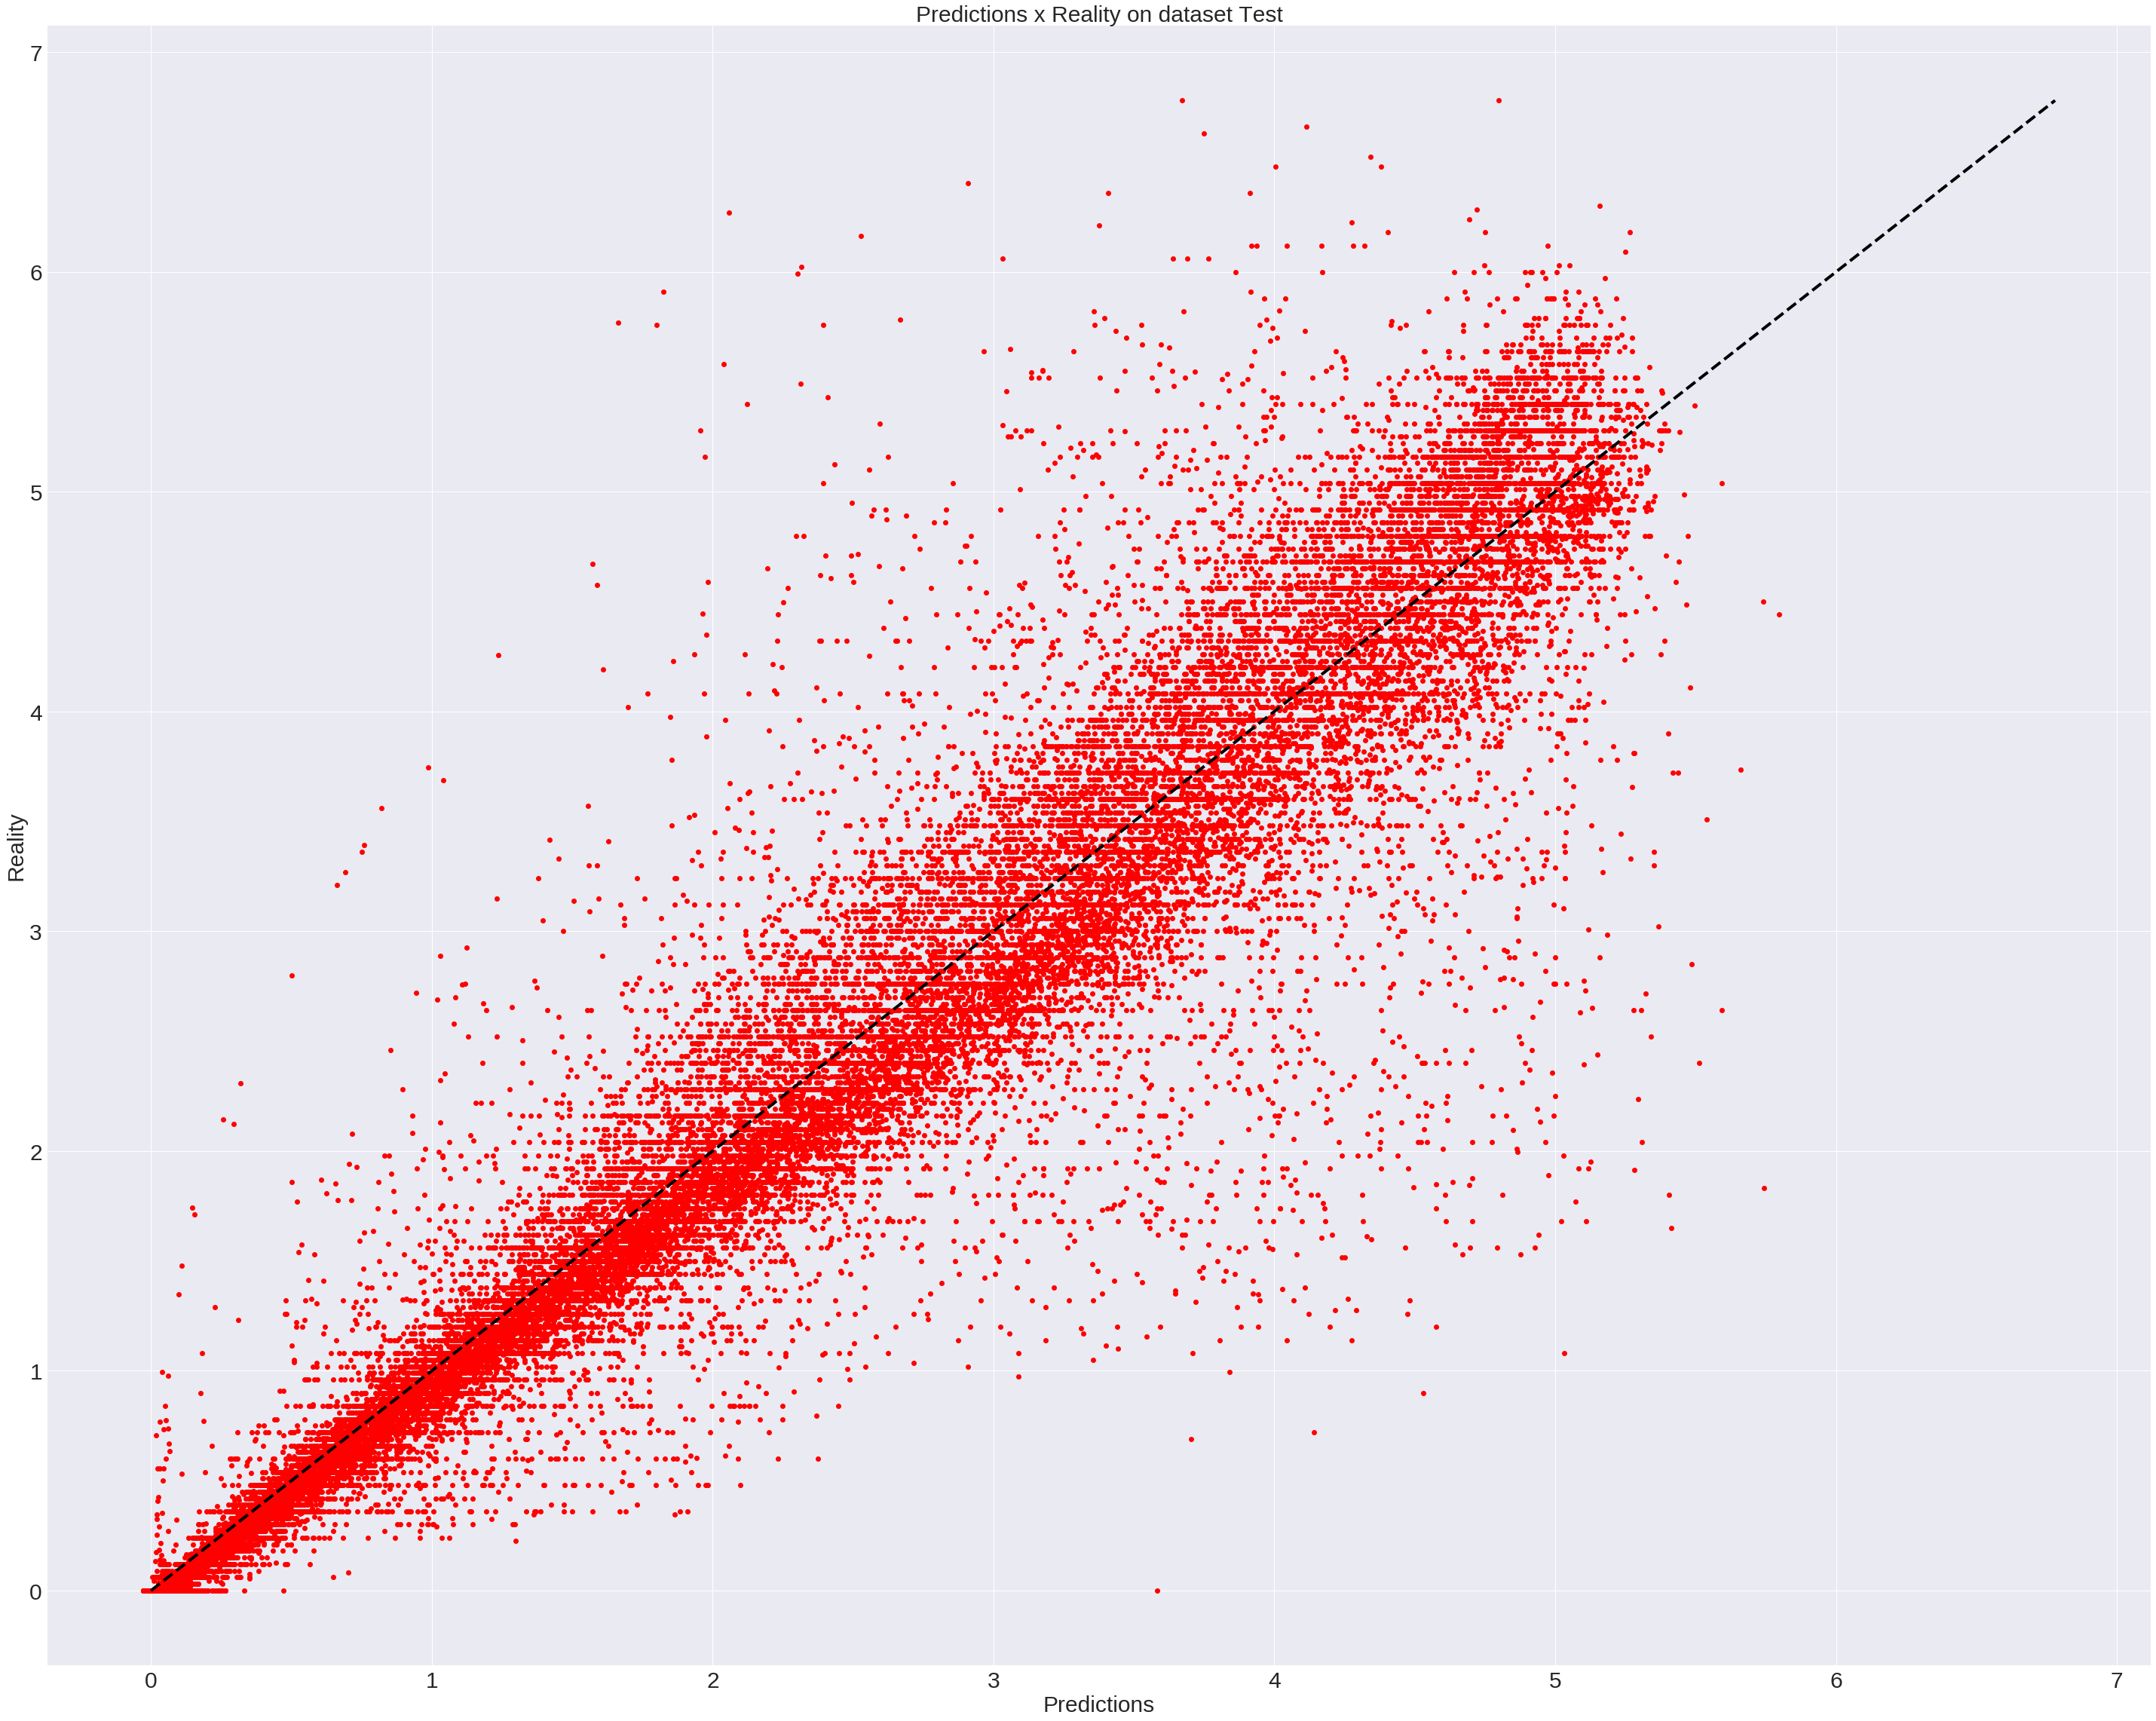

In [25]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(predictions.values, reality.values, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()

In [26]:
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))

def to_submit(pred_y,name_out):
    y_predict = list(itertools.islice(pred_y, test.shape[0]))
    y_predict = pd.DataFrame(prepro_y.inverse_transform(np.array(y_predict).reshape(len(y_predict),1)), columns = ['P'])
    y_predict = y_predict.join(buffer_datetime_test)
    y_predict.to_csv(name_out + '.csv',index=False)
    
to_submit(y_predict, "model3_predict")

# Leaky Relu

In [27]:
def leaky_relu(x):
    return tf.nn.relu(x) - 0.01 * tf.nn.relu(-x)

In [28]:
# Model
regressor_Leaky_Relu = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = leaky_relu, hidden_units=[200, 100, 50, 25, 12])
    
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor_Leaky_Relu.fit(input_fn=lambda: input_fn(training_set), steps=2000)

# Evaluation on the test set created by train_test_split
ev_Leaky_Relu = regressor_Leaky_Relu.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

In [29]:
# Display the score on the testing set
# 0.002X in average
loss_score2 = ev["loss"]
print("Final Loss on the testing set with Leaky Relu: {0:f}".format(loss_score2))

Final Loss on the testing set with Leaky Relu: 0.003652


In [30]:
# Predictions
y_predict_Leaky_Relu = regressor_Leaky_Relu.predict(input_fn=lambda: input_fn(test, pred = True))
to_submit(y_predict_Leaky_Relu, "model3_Leaky_Relu")

# elu

In [31]:
# Model
regressor_elu = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.elu, hidden_units=[200, 100, 50, 25, 12])
    
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor_elu.fit(input_fn=lambda: input_fn(training_set), steps=2000)

# Evaluation on the test set created by train_test_split
ev_elu = regressor_elu.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

loss_score3 = ev_elu["loss"]

In [32]:
print("Final Loss on the testing set with Elu: {0:f}".format(loss_score3))

Final Loss on the testing set with Elu: 0.003759


In [33]:
# Predictions
y_predict_elu = regressor_elu.predict(input_fn=lambda: input_fn(test, pred = True))
to_submit(y_predict_elu, "model3_elu")

# DNN

In [34]:
# Model
regressor_DNN = tf.contrib.learn.DNNRegressor(feature_columns = feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[1000])

In [35]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor_DNN.fit(input_fn = lambda: input_fn(training_set) , steps=2000)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7f0cfb0ae668>, 'hidden_units': [1000], 'feature_columns': (_RealValuedColumn(column_name='I', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='T', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='UV', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='WS', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='RH', dimension=1, default_value=None, dtype=tf.float32, normalizer=None)), 'optimizer': None, 'activation_fn': <function relu at 0x7f0d0a2b8510>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [36]:
ev_DNN = regressor_DNN.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)
loss_score5 = ev_DNN["loss"]

In [37]:
y_predict_DNN = regressor_DNN.predict(input_fn=lambda: input_fn(test, pred = True))    
to_submit(y_predict_DNN, "model3_shallow")